# Цель:

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании.

Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где
- 0 — совершенно неудовлетворён
- 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

# Задача 1: предсказание уровня удовлетворённости сотрудника
Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

# Описание данных:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

# Задача 2: предсказание увольнения сотрудника из компании

Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Описание данных:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- quit - увольнение сотрудника из компании

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков.

Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

# Импорты:

In [1]:
!pip install --upgrade scikit-learn

import sklearn
sklearn.__version__

'1.4.2'

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

In [4]:
!pip install phik -q
import phik

In [5]:
!pip install shap -q
import shap

## Задача:

### Загрузка данных

In [6]:
train_data = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

# Загрузка входных признаков тестовой выборки
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

# Загрузка целевого признака тестовой выборки
test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [7]:
train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [8]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [9]:
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [11]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [12]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [13]:
test_features.shape

(2000, 9)

In [14]:
train_data.shape

(4000, 10)

In [15]:
test_target.shape

(2000, 2)

# Выводы:

Имеем 3 датафрейма:

Тренировочная выборка:
- train_job_satisfaction_rate.csv

Входные признаки тестовой выборки:
- test_features.csv

Целевой признак тестовой выборки:
- test_target_job_satisfaction_rate.csv

Все данные загружены и имеют уместные типы, видим несколько пропусков в колонках dept и level в датафреймах train_data test_features

### Предобработка данных

#### Просмотрим уникальные значения

In [16]:
# Вывод уникальных значений
print("Уникальные значения в таблице test_features:")
for column in test_features.columns:
    unique_values = test_features[column].unique()
    print(f"{column}: {unique_values}")

print("\nУникальные значения в таблице train_data:")
for column in train_data.columns:
    unique_values = train_data[column].unique()
    print(f"{column}: {unique_values}")

print("\nУникальные значения в таблице test_target:")
for column in test_target.columns:
    unique_values = test_target[column].unique()
    print(f"{column}: {unique_values}")

Уникальные значения в таблице test_features:
id: [485046 686555 467458 ... 305653 160233 771859]
dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'low' 'high' ' ']
employment_years: [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [5 4 3 1 2]
salary: [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]

Уникальные значения в таблице train_data:
id: [155278 653870 184592 ... 533318 706868 338347]
dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'sinior' nan]

Видим опечатку в названии категории "sinior" в столбцах "level"

#### Исправляем опечатку

In [17]:
# Замена значений "sinior" на "senior" в столбце 'level' тренировочной выборки
train_data['level'] = train_data['level'].replace('sinior', 'senior')

# Замена значений "sinior" на "senior" в столбце 'level' тестовой выборки
test_features['level'] = test_features['level'].replace('sinior', 'senior')

#### Проверим датафреймы на наличие дубликатов

In [18]:
print("\nКоличество дубликатов в таблице test_features:", test_features.duplicated().sum())
print("\nКоличество дубликатов в таблице train_data:", train_data.duplicated().sum())
print("\nКоличество дубликатов в таблице test_target:", test_target.duplicated().sum())


Количество дубликатов в таблице test_features: 0

Количество дубликатов в таблице train_data: 0

Количество дубликатов в таблице test_target: 0


Дубликатов нет, идем дальше

Видим nan-ы и пропуски ' '

Надо проверить их количество

#### Проверим пропуски

In [19]:
print("\nПропущенные значения в таблице train_data:")
print(train_data.isna().sum())


Пропущенные значения в таблице train_data:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [20]:
# Замена ' ' на NaN в таблице train_data
train_data.replace(' ', np.nan, inplace=True)

#### Удалим пропуски в пайплайне

In [21]:
null_columns = ['dept', 'level', 'workload']

pipelines = [(column, Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))]), [column]) for column in null_columns]

transformer = ColumnTransformer(transformers=pipelines, remainder='passthrough', verbose_feature_names_out=False)
transformer.fit(train_data)

train_data = pd.DataFrame(transformer.transform(train_data), columns=transformer.get_feature_names_out())

train_data

,dept,level,workload,id,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,155278,2,no,no,1,24000,0.58
1,hr,junior,high,653870,2,no,no,5,38400,0.76
2,sales,junior,low,184592,1,no,no,2,12000,0.11
3,technology,junior,low,171431,4,no,no,2,18000,0.37
4,hr,junior,medium,693419,1,no,no,3,22800,0.2
...,...,...,...,...,...,...,...,...,...,...
3995,technology,junior,high,457950,2,no,no,3,46800,0.45
3996,sales,junior,medium,957499,2,no,no,4,21600,0.68
3997,sales,middle,low,533318,7,no,no,5,24000,0.76
3998,sales,junior,medium,706868,2,no,no,3,24000,0.48


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   id                     4000 non-null   object
 4   employment_years       4000 non-null   object
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   object
 8   salary                 4000 non-null   object
 9   job_satisfaction_rate  4000 non-null   object
dtypes: object(10)
memory usage: 312.6+ KB


In [23]:
print("\nУникальные значения в таблице train_data:")
for column in train_data.columns:
    unique_values = train_data[column].unique()
    print(f"{column}: {unique_values}")


Уникальные значения в таблице train_data:
dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing']
level: ['junior' 'middle' 'senior']
workload: ['medium' 'high' 'low']
id: [155278 653870 184592 ... 533318 706868 338347]
employment_years: [2 1 4 7 9 6 3 10 8 5]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [1 5 2 3 4]
salary: [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
job_satisfaction_rate: [0.58 0.76 0.11 0.37 0.2 0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57 0.16
 0.69 0.33 0.64 0.39 0.8 0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22 0.23 0.5
 0.35 0.3 0.77 0.88 0.59 0.21 0.36 0.85 

# Выполнили предобработку данных:
- Убрали пропуски
- Проверили дубликаты
- Исправили ошибки

### Исследовательский анализ данных

# Для наглядности построим графики для признаков:

#### Числовые:

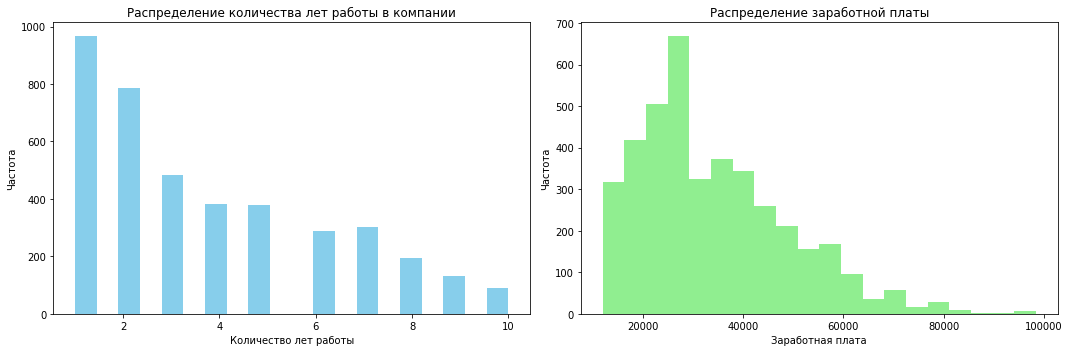

In [24]:
# Устанавливаем размер графиков
plt.figure(figsize=(15, 5))

# Гистограмма для количества лет работы в компании
plt.subplot(1, 2, 1)
plt.hist(train_data['employment_years'], bins=20, color='skyblue')
plt.title('Распределение количества лет работы в компании')
plt.xlabel('Количество лет работы')
plt.ylabel('Частота')

# Гистограмма для заработной платы
plt.subplot(1, 2, 2)
plt.hist(train_data['salary'], bins=20, color='lightgreen')
plt.title('Распределение заработной платы')
plt.xlabel('Заработная плата')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

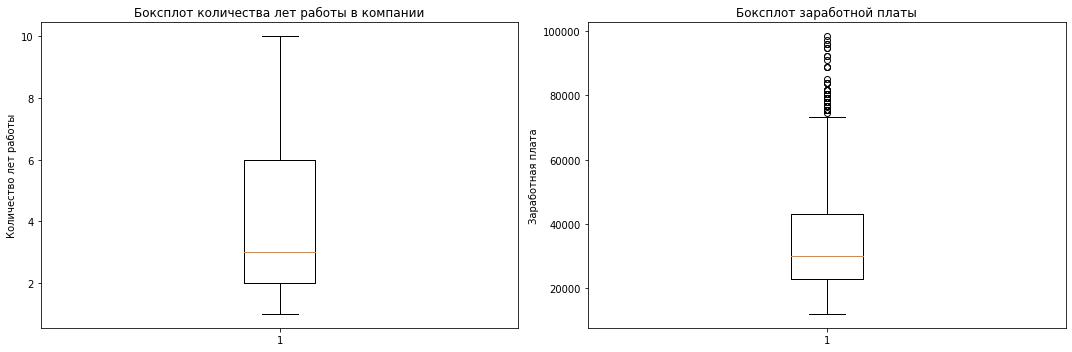

In [25]:
# Устанавливаем размер графика
plt.figure(figsize=(15, 5))

# Боксплот для количества лет работы в компании
plt.subplot(1, 2, 1)
plt.boxplot(train_data['employment_years'])
plt.title('Боксплот количества лет работы в компании')
plt.ylabel('Количество лет работы')

# Боксплот для заработной платы
plt.subplot(1, 2, 2)
plt.boxplot(train_data['salary'])
plt.title('Боксплот заработной платы')
plt.ylabel('Заработная плата')

plt.tight_layout()
plt.show()

#### Видим выбросы, но чтобы решить, удалять их или нет - посмотрим их количество

In [26]:
# Определяем пороговое значение для выбросов (примерно выше 70000, а если выше - их ещё меньше)
threshold = 70000

# Считаем количество значений выше порога в столбце salary
outliers_count = (train_data['salary'] > threshold).sum()

print("Количество строк с выбросами в столбце salary:", outliers_count)


Количество строк с выбросами в столбце salary: 85


In [27]:
# Вычисляем количество строк с выбросами
outliers_count = (train_data['salary'] > threshold).sum()

# Общее количество строк в столбце salary
total_rows = train_data.shape[0]

# Вычисляем процент строк с выбросами от общего количества строк
outliers_percentage = (outliers_count / total_rows) * 100

print("Процент строк с выбросами от общего количества строк в столбце salary:", outliers_percentage, "%")


Процент строк с выбросами от общего количества строк в столбце salary: 2.125 %


Выбивающихся значений всего 2%, так что можно их просто проигнорировать

#### Категориальные:

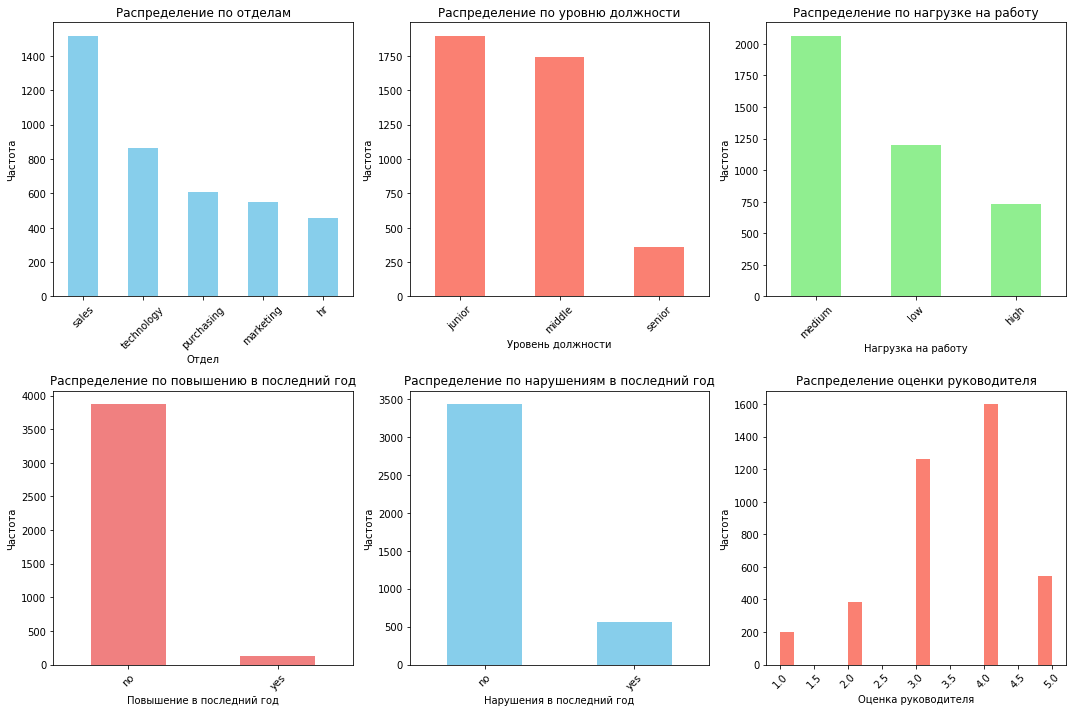

In [28]:
# Устанавливаем размер графиков
plt.figure(figsize=(15, 10))

# Столбчатая диаграмма для отдела
plt.subplot(2, 3, 1)
train_data['dept'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение по отделам')
plt.xlabel('Отдел')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для уровня должности
plt.subplot(2, 3, 2)
train_data['level'].value_counts().plot(kind='bar', color='salmon')
plt.title('Распределение по уровню должности')
plt.xlabel('Уровень должности')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для нагрузки на работу
plt.subplot(2, 3, 3)
train_data['workload'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Распределение по нагрузке на работу')
plt.xlabel('Нагрузка на работу')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для повышения в последний год
plt.subplot(2, 3, 4)
train_data['last_year_promo'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Распределение по повышению в последний год')
plt.xlabel('Повышение в последний год')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для нарушений в последний год
plt.subplot(2, 3, 5)
train_data['last_year_violations'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение по нарушениям в последний год')
plt.xlabel('Нарушения в последний год')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Гистограмма для оценки руководителя
plt.subplot(2, 3, 6)
plt.hist(train_data['supervisor_evaluation'], bins=20, color='salmon')
plt.title('Распределение оценки руководителя')
plt.xlabel('Оценка руководителя')
plt.ylabel('Частота')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Распределение выглядит нормальным, начиная от распределения оценцки руководителя со средним значением около 3.5-4, нагрузки и заканчивая распределением по должностям

#### Рассмотрим признаки:

In [29]:
# Уникальные значения категориальных признаков
print("Уникальные значения нагрузки на работу:", train_data['dept'].unique())
print("Уникальные значения нагрузки на работу:", train_data['level'].unique())
print("Уникальные значения нагрузки на работу:", train_data['workload'].unique())

print("Уникальные значения повышения в последний год:", train_data['last_year_promo'].unique())
print("Уникальные значения нарушений в последний год:", train_data['last_year_violations'].unique())
print("Уникальные значения оценки от руководителя в последний год:", train_data['supervisor_evaluation'].unique())

# Распределения числовых признаков
print("Распределение количества лет работы в компании:")
print(train_data['employment_years'].describe())
print("\nРаспределение оценки руководителя:")
print("\nРаспределение заработной платы:")
print(train_data['salary'].describe())

Уникальные значения нагрузки на работу: ['sales' 'hr' 'technology' 'purchasing' 'marketing']
Уникальные значения нагрузки на работу: ['junior' 'middle' 'senior']
Уникальные значения нагрузки на работу: ['medium' 'high' 'low']
Уникальные значения повышения в последний год: ['no' 'yes']
Уникальные значения нарушений в последний год: ['no' 'yes']
Уникальные значения оценки от руководителя в последний год: [1 5 2 3 4]
Распределение количества лет работы в компании:
count     4000
unique      10
top          1
freq       966
Name: employment_years, dtype: int64

Распределение оценки руководителя:

Распределение заработной платы:
count      4000
unique       68
top       24000
freq        187
Name: salary, dtype: int64


Матрица Корреляции Phik:


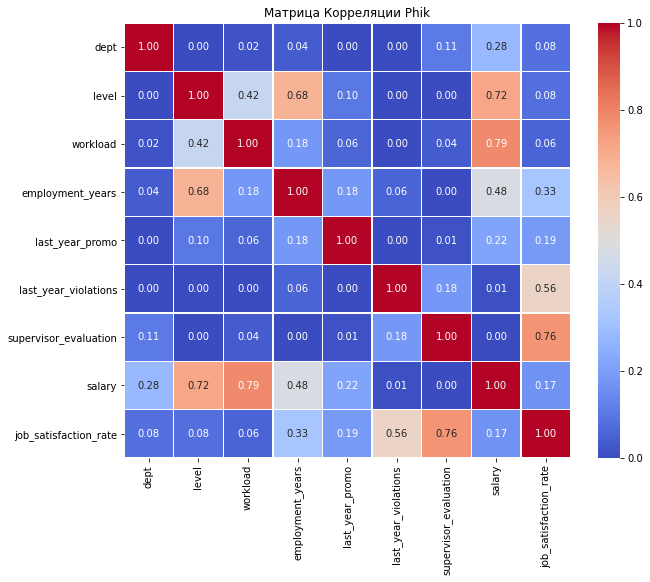

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,NaN,1.000000,NaN,0.682962,NaN,NaN,NaN,0.717761,NaN
workload,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,0.788820,NaN
employment_years,NaN,0.682962,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
last_year_promo,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
last_year_violations,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.560348
supervisor_evaluation,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.764364
salary,NaN,0.717761,0.78882,NaN,NaN,NaN,NaN,1.000000,NaN
job_satisfaction_rate,NaN,NaN,NaN,NaN,NaN,0.560348,0.764364,NaN,1.000000


In [30]:
# Определение списка непрерывных признаков
continuous_features = ['salary', 'job_satisfaction_rate']

# Удаляем столбец 'id' из фрейма данных перед вычислением матрицы корреляций Phik
train_data_no_id = train_data.drop(columns=['id'])

# Вычисление матрицы корреляций Phik с учетом списка непрерывных признаков и исключением столбца 'id'
correlation_matrix_phik = train_data_no_id.phik_matrix(interval_cols=continuous_features)

# Вывод матрицы корреляций
print("Матрица Корреляции Phik:")
#print(correlation_matrix_phik)

# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_phik, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица Корреляции Phik')
plt.show()

# Установка значения порога корреляции
threshold = 0.50

# Фильтрация матрицы корреляций
high_correlations = correlation_matrix_phik[correlation_matrix_phik.abs() > threshold]

# Вывод корреляций выше порога
high_correlations

Из матрицы корреляций можно сделать следующие наблюдения:

1. Уровень должности (level) и зарплата (salary) имеют сильную положительную корреляцию, так как обычно уровень должности влияет на уровень оплаты труда

2. Нагрузка на работу (workload) и зарплата (salary) также имеют сильную положительную корреляцию, так как более высокая нагрузка часто соответствует более высокой зарплате, что вполне логично

3. Оценка руководителя (supervisor_evaluation) и уровень должности (level) имеют положительную корреляцию. Вероятно, сотрудники более высокого уровня должности получают более высокие оценки от своих руководителей

4. Оценка руководителя (supervisor_evaluation) и удовлетворенность работой (job_satisfaction_rate) также имеют положительную корреляцию, и удовлетворённые своей работой люди более продуктивны и получают лучшие оценки своей работы

5. Удовлетворенность работой (job_satisfaction_rate) и нарушения в последний год (last_year_violations) имеют некоторую положительную корреляцию. Это может означать, что количество нарушений растет с понижением удовлетворённости своей работой

# Наблюдения и выводы:

workload:
- Уникальные значения: 'medium', 'high', 'low'
- Требуется закодировать OrdinalEncoder

level:
- Уникальные значения: 'junior', 'middle', 'senior'
- Требуется закодировать OrdinalEncoder

supervisor_evaluation:
- Уникальные значения (по возрастанию оценки от 1 до 5: '1', '2', '3', '4', '5'
- Требуется закодировать OrdinalEncoder

dept:
- Уникальные значения: 'sales' 'hr' 'technology' 'purchasing' 'marketing'
- Требуется закодировать методом One-Hot

last_year_promo и last_year_violations:
- Уникальные значения: 'no', 'yes'
- Требуется закодировать методом One-Hot

employment_years:
- Требуется масштабирование признака

salary:
- Требуется масштабирование признака

Исходя из этой информации, предлагается выполнить следующие шаги предобработки данных:
- 'last_year_promo' и 'last_year_violations' - непорядковые признаки, их нужно перенести в OneHotEncoder
- 'level', 'workload' - порядковые признаки, их нужно перенести в ord_col с помощью OrdinalEncoder
- Масштабировать числовые признаки 'employment_years', 'supervisor_evaluation' и 'salary' с помощью StandardScaler

Провели исследовательский анализ данных и сделали выводы о том, как их нужно подготовить в пайплайне

### Подготовка данных

#### Создание общей тестовой выборки и сортировка(до создания индексов)

In [31]:
test_features = pd.merge(test_features, test_target, on='id', sort=True)
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.80
1,100480,marketing,junior,low,4,no,no,4,16800,0.84
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,0.75
4,100692,sales,middle,high,6,no,no,4,48000,0.69


In [32]:
train_data = train_data.sort_values(by=['id']).set_index('id')
test_features = test_features.sort_values(by=['id']).set_index('id')

In [33]:
print(train_data.info(), '\n----------------')
train_data = train_data.drop_duplicates()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   object
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   object
 7   salary                 4000 non-null   object
 8   job_satisfaction_rate  4000 non-null   object
dtypes: object(9)
memory usage: 312.5+ KB
None 
----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3752 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   3752 non-null   ob

#### Задание константы RANDOM_STATE и подготовка данных

In [34]:
RANDOM_STATE = 42

X_train_js = train_data.drop('job_satisfaction_rate', axis=1)
y_train_js = train_data['job_satisfaction_rate'] 
X_test_js = test_features.drop('job_satisfaction_rate', axis=1)
y_test_js = test_features['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [35]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [36]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

X_train_js_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_js), columns=data_preprocessor.get_feature_names_out())
X_test_js_transformed = pd.DataFrame(data_preprocessor.transform(X_test_js), columns=data_preprocessor.get_feature_names_out())

# Итог:

1. Проведели кодирование (использовано два кодировщика ohe - OneHotEncoder, ord - OrdinalEncoder)
2. Масштабировали данные

### Обучение моделей

In [37]:
def smape_js(y_true, y_pred):
    return 100/len(y_true) * np.sum( np.abs(y_true - y_pred) /
    ((np.abs(y_true) + np.abs(y_pred))/2) ) 
   
smape_scorer = make_scorer(score_func=smape_js, greater_is_better=False)

In [38]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 5, 10, 15],
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [39]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_js, y_train_js)

print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape_js(y_test_js, rs.predict(X_test_js)), 4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.3271


### Оформление выводов

Модель дерева решений демонстрирует лучший результат по метрике SMAPE на тестовой выборке, чем линейная регрессия.
- Для дерева решений SMAPE составил около 14.3
- Для линейной регрессии этот показатель оказался выше, составив около 26.8

Дерево решений лучше подходит для данной задачи из-за:
- Нелинейной природы данных или наличия в данных и нелинейных взаимосвязей между признаками и целевой переменной
- Дерево решений более гибко подстраивается под данные и может лучше обрабатывать нелинейные зависимости, чем линейная регрессия

Наверное для дерева решений использовались оптимальные гиперпараметры, что могло способствовать улучшению его производительности

## Задача:

### Загрузка данных

In [40]:
# Загрузка тренировочной выборки
train_data_quit = pd.read_csv("/datasets/train_quit.csv")

# Загрузка входных признаков тестовой выборки
test_features_quit = pd.read_csv("/datasets/test_features.csv")

# Загрузка целевого признака тестовой выборки
test_target_quit = pd.read_csv("/datasets/test_target_quit.csv")

In [41]:
train_data_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [42]:
test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [43]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [44]:
print("Размер тренировочной выборки:", train_data_quit.shape)
print("Размер тестовых признаков:", test_features.shape)
print("Размер целевого признака тестовой выборки:", test_target.shape)

Размер тренировочной выборки: (4000, 10)
Размер тестовых признаков: (2000, 9)
Размер целевого признака тестовой выборки: (2000, 2)


In [45]:
train_data_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [46]:
test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [47]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


# Выводы:

Имеем 3 датафрейма:

Тренировочная выборка:
- train_data_quit.info()

Входные признаки тестовой выборки:
- test_features_quit.csv

Целевой признак тестовой выборки:
- test_target_quit.info()

Все данные загружены и имеют уместные типы, видим несколько пропусков в колонках dept и level в датафреймах test_features_quit

### Предобработка данных

In [48]:
print("\nУникальные значения в таблице train_data_quit:")
for column in train_data_quit.columns:
    unique_values = train_data_quit[column].unique()
    print(f"{column}: {unique_values}")
    
# Вывод уникальных значений
print("Уникальные значения в таблице test_features_quit:")
for column in test_features_quit.columns:
    unique_values = test_features_quit[column].unique()
    print(f"{column}: {unique_values}")

print("\nУникальные значения в таблице test_target_quit:")
for column in test_target_quit.columns:
    unique_values = test_target_quit[column].unique()
    print(f"{column}: {unique_values}")


Уникальные значения в таблице train_data_quit:
id: [723290 814010 155091 ... 536432 692133 853842]
dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
employment_years: [ 2  5  1  8  4  7  3  9  6 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [4 1 3 5 2]
salary: [54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]
quit: ['no' 'yes']
Уникальные значения в таблице test_features_quit:
id: [485046 686555 467458 ... 305653 160233 771859]
dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
leve

Видим опечатку в названии категории "sinior" в столбцах "level"

#### Исправляем опечатку

In [49]:
# Замена значений "sinior" на "senior" в столбце 'level' тренировочной выборки
train_data_quit['level'] = train_data_quit['level'].replace('sinior', 'senior')

# Замена значений "sinior" на "senior" в столбце 'level' тестовой выборки
test_features_quit['level'] = test_features_quit['level'].replace('sinior', 'senior')

#### Проверим датафреймы на наличие дубликатов

In [50]:
print("\nКоличество дубликатов в таблице test_features_quit:", test_features_quit.duplicated().sum())
print("\nКоличество дубликатов в таблице train_data_quit:", train_data_quit.duplicated().sum())
print("\nКоличество дубликатов в таблице test_target_quit:", test_target_quit.duplicated().sum())


Количество дубликатов в таблице test_features_quit: 0

Количество дубликатов в таблице train_data_quit: 0

Количество дубликатов в таблице test_target_quit: 0


Дубликатов нет, идем дальше

Видим nan-ы и пропуски ' '

Надо проверить их количество

#### Проверим пропуски

In [51]:
# Проверка пропусков
print("Пропущенные значения в таблице test_features:")
print(train_data_quit.isna().sum())

Пропущенные значения в таблице test_features:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [52]:
# Замена ' ' на NaN в таблице test_features
train_data_quit.replace(' ', np.nan, inplace=True)

#### Удалим пропуски в пайплайне уже в 2.5

# Выполнили предобработку данных:
- Убрали пропуски
- Проверили дубликаты
- Исправили ошибки

### Исследовательский анализ данных

# Для наглядности построим графики для признаков:

# train

#### Числовые:

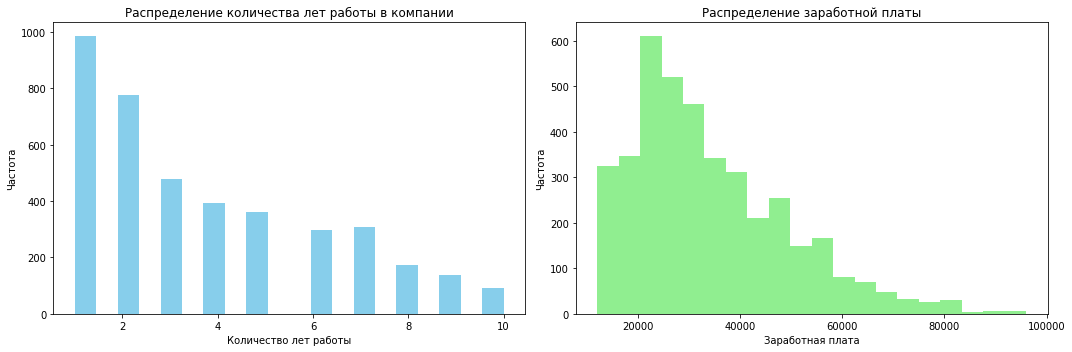

In [53]:
# Устанавливаем размер графиков
plt.figure(figsize=(15, 5))

# Гистограмма для количества лет работы в компании
plt.subplot(1, 2, 1)
plt.hist(train_data_quit['employment_years'], bins=20, color='skyblue')
plt.title('Распределение количества лет работы в компании')
plt.xlabel('Количество лет работы')
plt.ylabel('Частота')

# Гистограмма для заработной платы
plt.subplot(1, 2, 2)
plt.hist(train_data_quit['salary'], bins=20, color='lightgreen')
plt.title('Распределение заработной платы')
plt.xlabel('Заработная плата')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

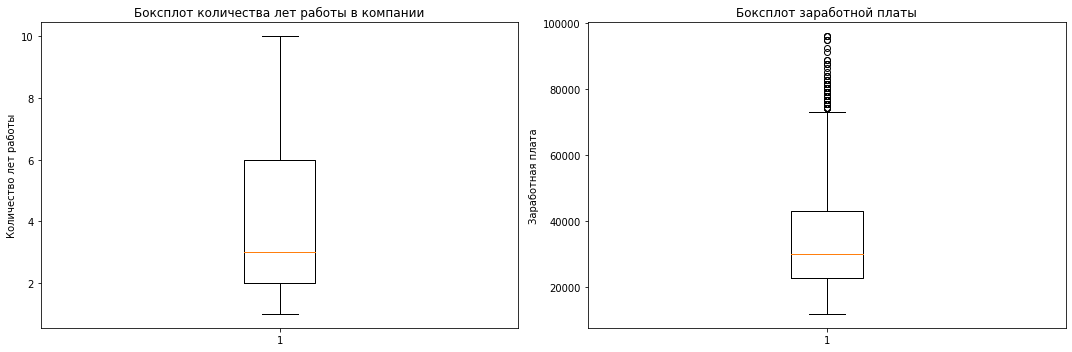

In [54]:
# Устанавливаем размер графика
plt.figure(figsize=(15, 5))

# Боксплот для количества лет работы в компании
plt.subplot(1, 2, 1)
plt.boxplot(train_data_quit['employment_years'])
plt.title('Боксплот количества лет работы в компании')
plt.ylabel('Количество лет работы')

# Боксплот для заработной платы
plt.subplot(1, 2, 2)
plt.boxplot(train_data_quit['salary'])
plt.title('Боксплот заработной платы')
plt.ylabel('Заработная плата')

plt.tight_layout()
plt.show()

#### Видим выбросы, но чтобы решить, удалять их или нет - посмотрим их количество

In [55]:
# Определяем пороговое значение для выбросов (примерно выше 70000, а если выше - их ещё меньше)
threshold = 70000

# Считаем количество значений выше порога в столбце salary
outliers_count = (train_data_quit['salary'] > threshold).sum()

print("Количество строк с выбросами в столбце salary:", outliers_count)

Количество строк с выбросами в столбце salary: 104


In [56]:
# Вычисляем количество строк с выбросами
outliers_count = (train_data_quit['salary'] > threshold).sum()

# Общее количество строк в столбце salary
total_rows = train_data_quit.shape[0]

# Вычисляем процент строк с выбросами от общего количества строк
outliers_percentage = (outliers_count / total_rows) * 100

print("Процент строк с выбросами от общего количества строк в столбце salary:", outliers_percentage, "%")

Процент строк с выбросами от общего количества строк в столбце salary: 2.6 %


Выбивающихся значений менее 3%, так что можно их просто проигнорировать

#### Категориальные:

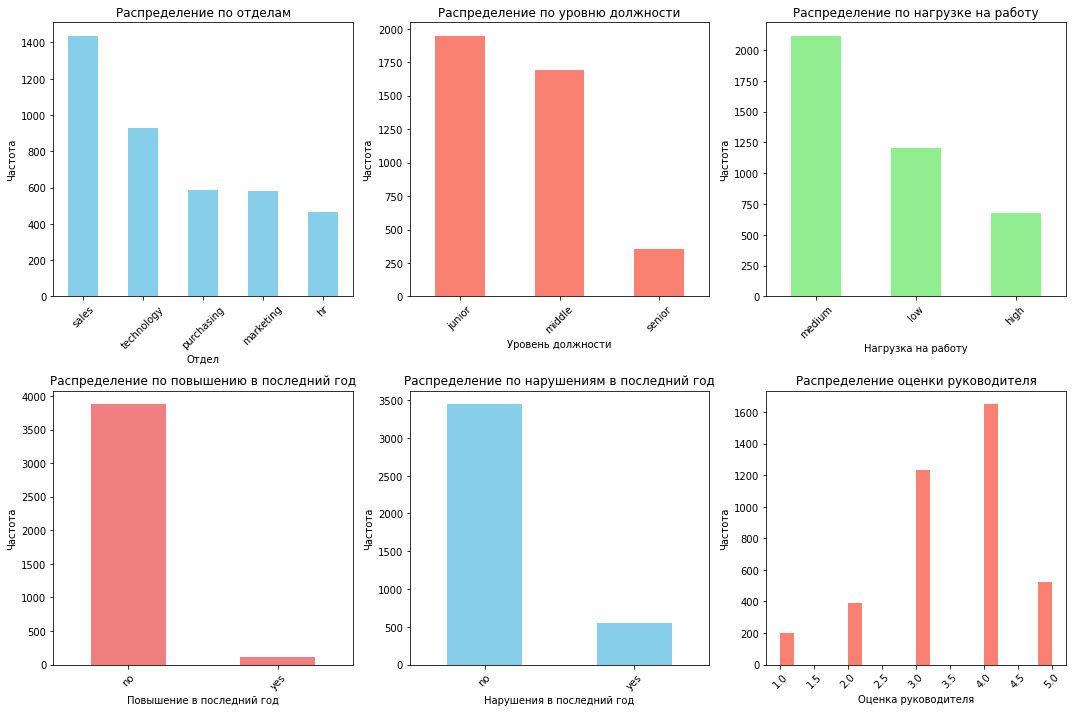

In [57]:
# Устанавливаем размер графиков
plt.figure(figsize=(15, 10))

# Столбчатая диаграмма для отдела
plt.subplot(2, 3, 1)
train_data_quit['dept'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение по отделам')
plt.xlabel('Отдел')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для уровня должности
plt.subplot(2, 3, 2)
train_data_quit['level'].value_counts().plot(kind='bar', color='salmon')
plt.title('Распределение по уровню должности')
plt.xlabel('Уровень должности')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для нагрузки на работу
plt.subplot(2, 3, 3)
train_data_quit['workload'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Распределение по нагрузке на работу')
plt.xlabel('Нагрузка на работу')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для повышения в последний год
plt.subplot(2, 3, 4)
train_data_quit['last_year_promo'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Распределение по повышению в последний год')
plt.xlabel('Повышение в последний год')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для нарушений в последний год
plt.subplot(2, 3, 5)
train_data_quit['last_year_violations'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение по нарушениям в последний год')
plt.xlabel('Нарушения в последний год')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Гистограмма для оценки руководителя
plt.subplot(2, 3, 6)
plt.hist(train_data_quit['supervisor_evaluation'], bins=20, color='salmon')
plt.title('Распределение оценки руководителя')
plt.xlabel('Оценка руководителя')
plt.ylabel('Частота')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Распределение выглядит нормальным, начиная от распределения оценцки руководителя со средним значением около 3.5-4, нагрузки и заканчивая распределением по должностям

Матрица Корреляции Phik:


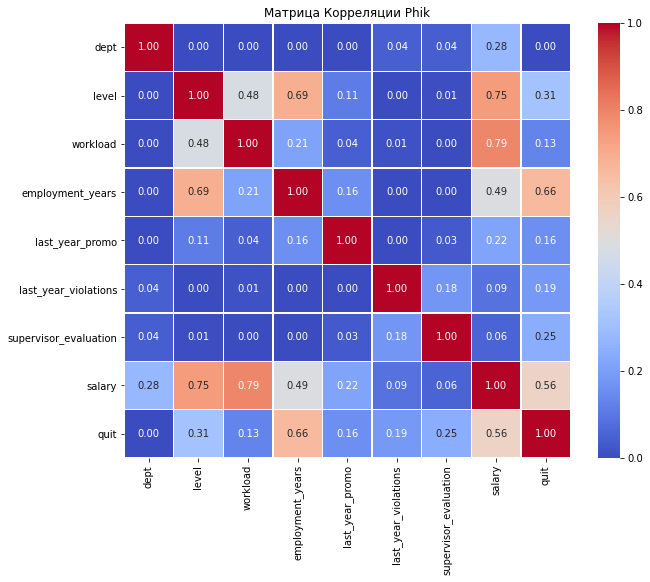

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,NaN,1.000000,NaN,0.692676,NaN,NaN,NaN,0.745104,NaN
workload,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.793876,NaN
employment_years,NaN,0.692676,NaN,1.000000,NaN,NaN,NaN,NaN,0.659093
last_year_promo,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
last_year_violations,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
supervisor_evaluation,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
salary,NaN,0.745104,0.793876,NaN,NaN,NaN,NaN,1.000000,0.564154
quit,NaN,NaN,NaN,0.659093,NaN,NaN,NaN,0.564154,1.000000


In [58]:
# Определение списка непрерывных признаков
continuous_features = ['salary', 'job_satisfaction_rate']

# Удаляем столбец 'id' из фрейма данных перед вычислением матрицы корреляций Phik
train_data_quit_no_id = train_data_quit.drop(columns=['id'])

# Вычисление матрицы корреляций Phik с учетом списка непрерывных признаков и исключением столбца 'id'
correlation_matrix_phik = train_data_quit_no_id.phik_matrix(interval_cols=continuous_features)

# Вывод матрицы корреляций
print("Матрица Корреляции Phik:")
#print(correlation_matrix_phik)

# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_phik, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица Корреляции Phik')
plt.show()

# Установка значения порога корреляции
threshold = 0.50

# Фильтрация матрицы корреляций
high_correlations = correlation_matrix_phik[correlation_matrix_phik.abs() > threshold]

# Вывод корреляций выше порога
high_correlations

# test

#### Числовые:

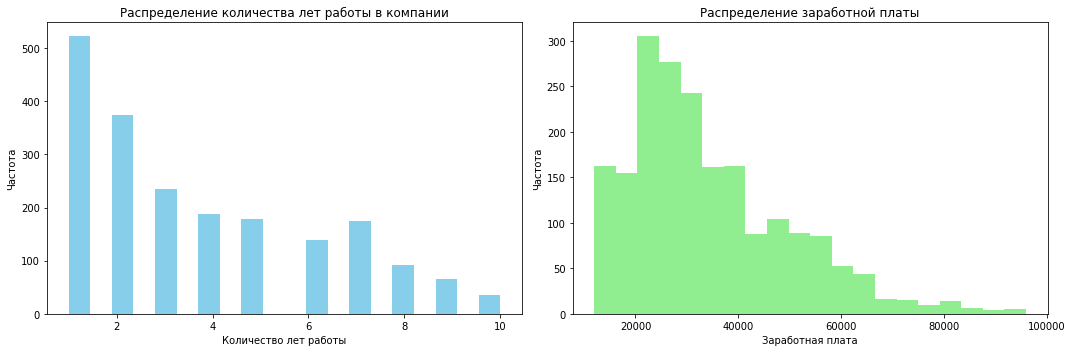

In [59]:
# Устанавливаем размер графиков
plt.figure(figsize=(15, 5))

# Гистограмма для количества лет работы в компании
plt.subplot(1, 2, 1)
plt.hist(test_features_quit['employment_years'], bins=20, color='skyblue')
plt.title('Распределение количества лет работы в компании')
plt.xlabel('Количество лет работы')
plt.ylabel('Частота')

# Гистограмма для заработной платы
plt.subplot(1, 2, 2)
plt.hist(test_features_quit['salary'], bins=20, color='lightgreen')
plt.title('Распределение заработной платы')
plt.xlabel('Заработная плата')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

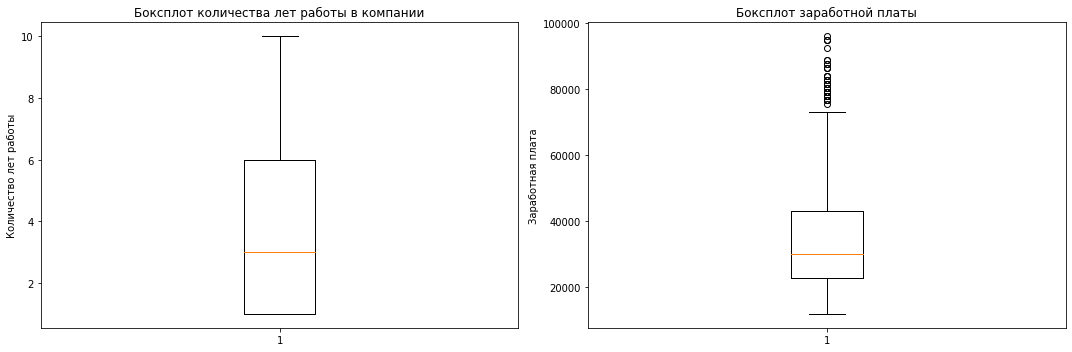

In [60]:
# Устанавливаем размер графика
plt.figure(figsize=(15, 5))

# Боксплот для количества лет работы в компании
plt.subplot(1, 2, 1)
plt.boxplot(test_features_quit['employment_years'])
plt.title('Боксплот количества лет работы в компании')
plt.ylabel('Количество лет работы')

# Боксплот для заработной платы
plt.subplot(1, 2, 2)
plt.boxplot(test_features_quit['salary'])
plt.title('Боксплот заработной платы')
plt.ylabel('Заработная плата')

plt.tight_layout()
plt.show()

#### Видим выбросы, но чтобы решить, удалять их или нет - посмотрим их количество

In [61]:
# Определяем пороговое значение для выбросов (примерно выше 70000, а если выше - их ещё меньше)
threshold = 70000

# Считаем количество значений выше порога в столбце salary
outliers_count = (test_features_quit['salary'] > threshold).sum()

print("Количество строк с выбросами в столбце salary:", outliers_count)

Количество строк с выбросами в столбце salary: 54


In [62]:
# Вычисляем количество строк с выбросами
outliers_count = (test_features_quit['salary'] > threshold).sum()

# Общее количество строк в столбце salary
total_rows = test_features_quit.shape[0]

# Вычисляем процент строк с выбросами от общего количества строк
outliers_percentage = (outliers_count / total_rows) * 100

print("Процент строк с выбросами от общего количества строк в столбце salary:", outliers_percentage, "%")

Процент строк с выбросами от общего количества строк в столбце salary: 2.7 %


Выбивающихся значений менее 3%, так что можно их просто проигнорировать

#### Категориальные:

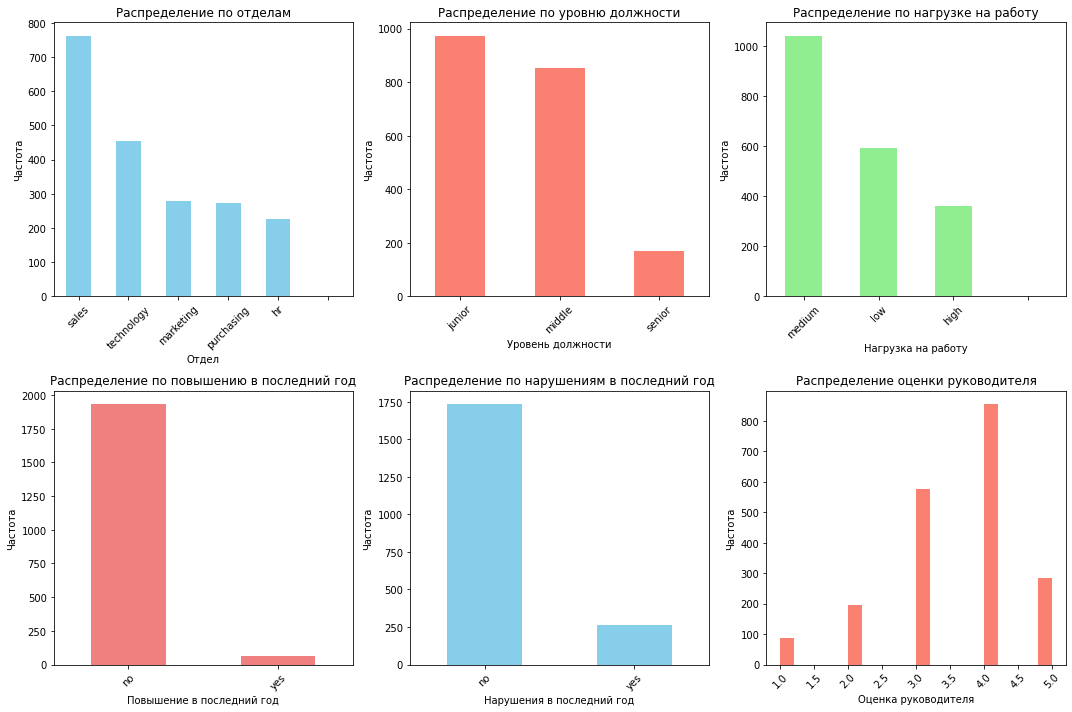

In [63]:
# Устанавливаем размер графиков
plt.figure(figsize=(15, 10))

# Столбчатая диаграмма для отдела
plt.subplot(2, 3, 1)
test_features_quit['dept'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение по отделам')
plt.xlabel('Отдел')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для уровня должности
plt.subplot(2, 3, 2)
test_features_quit['level'].value_counts().plot(kind='bar', color='salmon')
plt.title('Распределение по уровню должности')
plt.xlabel('Уровень должности')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для нагрузки на работу
plt.subplot(2, 3, 3)
test_features_quit['workload'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Распределение по нагрузке на работу')
plt.xlabel('Нагрузка на работу')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для повышения в последний год
plt.subplot(2, 3, 4)
test_features_quit['last_year_promo'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Распределение по повышению в последний год')
plt.xlabel('Повышение в последний год')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Столбчатая диаграмма для нарушений в последний год
plt.subplot(2, 3, 5)
test_features_quit['last_year_violations'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение по нарушениям в последний год')
plt.xlabel('Нарушения в последний год')
plt.ylabel('Частота')
plt.xticks(rotation=45)

# Гистограмма для оценки руководителя
plt.subplot(2, 3, 6)
plt.hist(test_features_quit['supervisor_evaluation'], bins=20, color='salmon')
plt.title('Распределение оценки руководителя')
plt.xlabel('Оценка руководителя')
plt.ylabel('Частота')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Распределение выглядит нормальным, начиная от распределения оценцки руководителя со средним значением около 3.5-4, нагрузки и заканчивая распределением по должностям

Матрица Корреляции Phik:


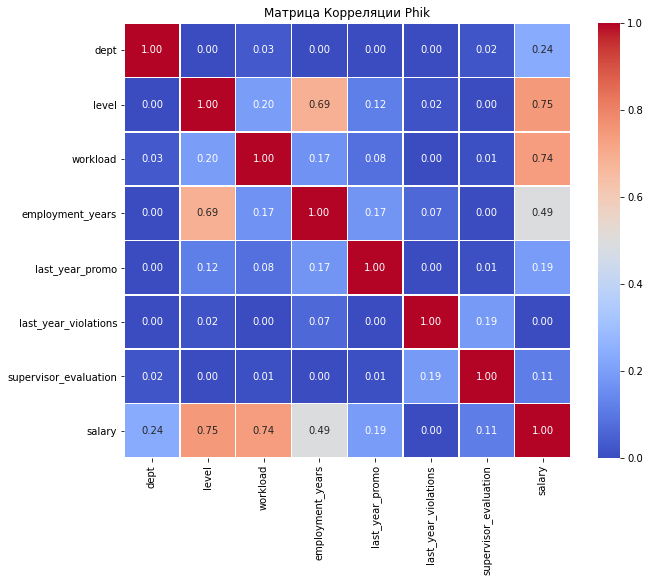

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
dept,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,NaN,1.000000,NaN,0.689666,NaN,NaN,NaN,0.748998
workload,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.739462
employment_years,NaN,0.689666,NaN,1.000000,NaN,NaN,NaN,NaN
last_year_promo,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
last_year_violations,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
supervisor_evaluation,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
salary,NaN,0.748998,0.739462,NaN,NaN,NaN,NaN,1.000000


In [64]:
# Определение списка непрерывных признаков
continuous_features = ['salary', 'job_satisfaction_rate']

# Удаляем столбец 'id' из фрейма данных перед вычислением матрицы корреляций Phik
test_features_quit_no_id = test_features_quit.drop(columns=['id'])

# Вычисление матрицы корреляций Phik с учетом списка непрерывных признаков и исключением столбца 'id'
correlation_matrix_phik = test_features_quit_no_id.phik_matrix(interval_cols=continuous_features)

# Вывод матрицы корреляций
print("Матрица Корреляции Phik:")
#print(correlation_matrix_phik)

# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_phik, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица Корреляции Phik')
plt.show()

# Установка значения порога корреляции
threshold = 0.50

# Фильтрация матрицы корреляций
high_correlations = correlation_matrix_phik[correlation_matrix_phik.abs() > threshold]

# Вывод корреляций выше порога
high_correlations

#### Составление портрета "уволившегося сотрудника"

##### Подсчет доли уволившихся сотрудников по отделам


Доля уволившихся сотрудников по отделам:
quit              no       yes
dept                          
hr          0.750000  0.250000
marketing   0.719931  0.280069
purchasing  0.717687  0.282313
sales       0.716968  0.283032
technology  0.702586  0.297414


<Figure size 720x432 with 0 Axes>

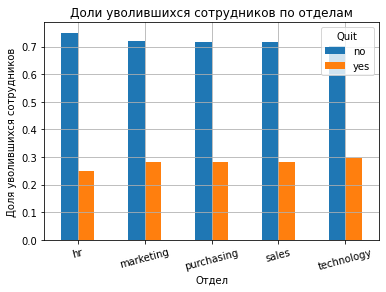

In [65]:
quit_by_dept = train_data_quit.groupby('dept')['quit'].value_counts(normalize=True).unstack()
print("\nДоля уволившихся сотрудников по отделам:")
print(quit_by_dept)

# Визуализация долей уволившихся сотрудников по отделам
plt.figure(figsize=(10, 6))
quit_by_dept.plot(kind='bar', stacked=False)
plt.title("Доли уволившихся сотрудников по отделам")
plt.xlabel("Отдел")
plt.ylabel("Доля уволившихся сотрудников")
plt.xticks(rotation=15)
plt.legend(title="Quit")
plt.grid(True)
plt.show()

##### Сравнение средней зарплаты уволившихся и оставшихся сотрудников по отделам

<Figure size 1008x576 with 0 Axes>

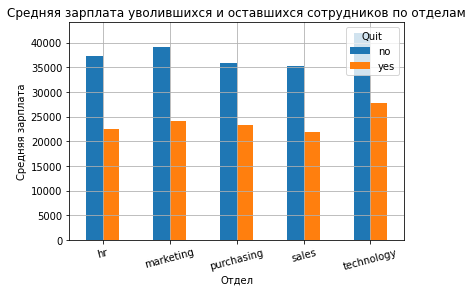

In [66]:
salary_comparison_by_dept = train_data_quit.groupby(['dept', 'quit'])['salary'].mean().unstack()

# Визуализация
plt.figure(figsize=(14, 8))
salary_comparison_by_dept.plot(kind='bar', stacked=False)
plt.title("Средняя зарплата уволившихся и оставшихся сотрудников по отделам")
plt.xlabel("Отдел")
plt.ylabel("Средняя зарплата")
plt.xticks(rotation=15)
plt.legend(title="Quit")
plt.grid(True)
plt.show()

#### Проверка гипотезы о том, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

In [67]:
test_features_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


In [68]:
test_target_quit

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


In [69]:
# Объединение датафреймов test_features_quit и test_target_quit по столбцу id
comparison_data_quit = pd.merge(test_features_quit, test_target_quit, on='id', how='inner')

# Объединение с test_target_job_satisfaction_rate по столбцу id
comparison_data_quit = pd.merge(comparison_data_quit, test_target, on='id', how='inner')

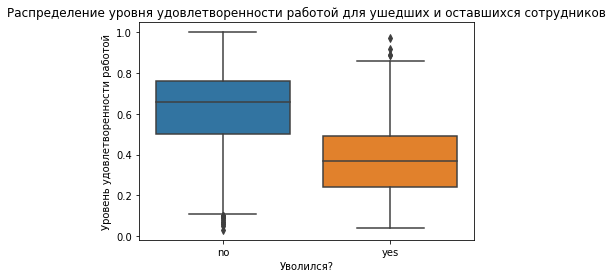

In [70]:
# Построение ящиков с усами для уровня удовлетворенности работой
sns.boxplot(x="quit", y="job_satisfaction_rate", data=comparison_data_quit)

# Настройка заголовка и осей
plt.title("Распределение уровня удовлетворенности работой для ушедших и оставшихся сотрудников")
plt.xlabel("Уволился?")
plt.ylabel("Уровень удовлетворенности работой")

# Отображение графика
plt.show()

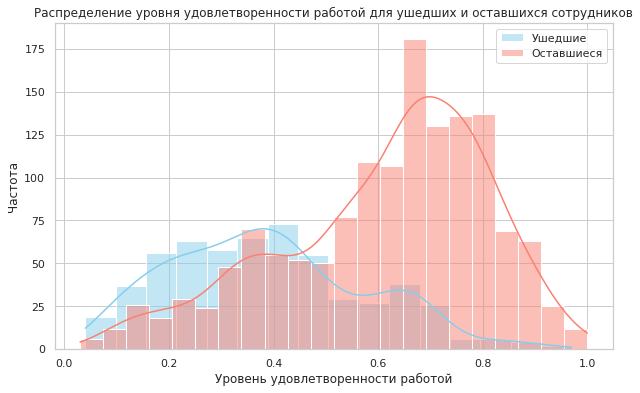

In [71]:
# Настройка стиля и размера графика
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Построение гистограммы для уровня удовлетворенности работой у ушедших сотрудников
sns.histplot(comparison_data_quit[comparison_data_quit['quit'] == 'yes']['job_satisfaction_rate'], color='skyblue', label='Ушедшие', kde=True)

# Построение гистограммы для уровня удовлетворенности работой у оставшихся сотрудников
sns.histplot(comparison_data_quit[comparison_data_quit['quit'] == 'no']['job_satisfaction_rate'], color='salmon', label='Оставшиеся', kde=True)

# Настройка заголовка и осей
plt.title("Распределение уровня удовлетворенности работой для ушедших и оставшихся сотрудников")
plt.xlabel("Уровень удовлетворенности работой")
plt.ylabel("Частота")

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

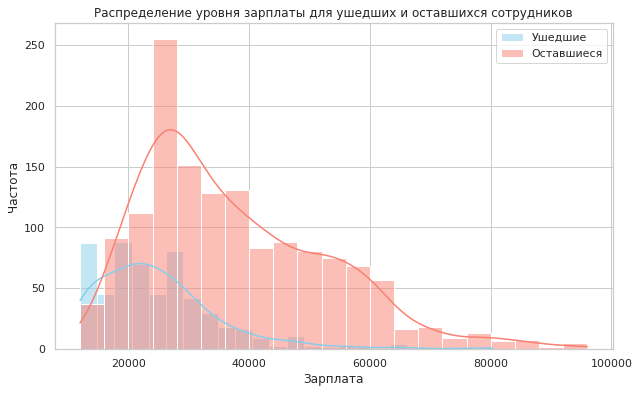

In [72]:
# Настройка стиля и размера графика
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Построение гистограммы для уровня удовлетворенности работой у ушедших сотрудников
sns.histplot(comparison_data_quit[comparison_data_quit['quit'] == 'yes']['salary'], color='skyblue', label='Ушедшие', kde=True)

# Построение гистограммы для уровня удовлетворенности работой у оставшихся сотрудников
sns.histplot(comparison_data_quit[comparison_data_quit['quit'] == 'no']['salary'], color='salmon', label='Оставшиеся', kde=True)

# Настройка заголовка и осей
plt.title("Распределение уровня зарплаты для ушедших и оставшихся сотрудников")
plt.xlabel("Зарплата")
plt.ylabel("Частота")

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

# Можно с уверенностью говорить о значительной корреляции вероятности увольнения сотрудника с низкой удовлетворенностью своей работой, ориентируясь на графики

### Добавление нового входного признака

#### Создание общей тестовой выборки и сортировка(до создания индексов)

In [73]:
test_features_quit = pd.merge(test_features_quit, test_target_quit, on='id', sort=True)
print(test_features_quit.info())
test_features_quit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,100298,hr,junior,low,2,no,no,4,19200,no
1,100480,marketing,junior,low,4,no,no,4,16800,no
2,100503,purchasing,middle,high,5,no,no,4,55200,no
3,100610,sales,middle,medium,5,no,no,4,43200,no
4,100692,sales,middle,high,6,no,no,4,48000,no


#### Добавление нового  признака

In [74]:
train_data_quit['job_satisfaction_rate'] = rs.predict(train_data_quit)
test_features_quit['job_satisfaction_rate'] = rs.predict(test_features_quit)
train_data_quit.info(), test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dt

(None, None)

####  Установка столбца "id" в качестве индекса

In [75]:
train_data_quit = train_data_quit.sort_values(by=['id']).set_index('id')
test_features_quit = test_features_quit.sort_values(by=['id']).set_index('id')

In [76]:
print(train_data_quit.info(), '\n----------------')
train_data_quit = train_data_quit.drop_duplicates()
train_data_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB
None 
----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ----

### Подготовка данных

#### Импорт LabelEncoder, чтобы кодировать таргет

In [77]:
from sklearn.preprocessing import LabelEncoder

#### Подготовка данных

In [78]:
lab_enc = LabelEncoder()
lab_enc.fit_transform(train_data_quit['quit'].unique())
print('Меняем', lab_enc.classes_, 'на', lab_enc.transform(lab_enc.classes_))
train_data_quit['quit'] = lab_enc.transform(train_data_quit['quit'])
test_features_quit['quit'] = lab_enc.transform(test_features_quit['quit'])

X_train_qt = train_data_quit.drop('quit', axis=1)
y_train_qt = train_data_quit['quit'] 
X_test_qt = test_features_quit.drop('quit', axis=1)
y_test_qt = test_features_quit['quit']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

X_train_qt_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_qt), columns=data_preprocessor.get_feature_names_out())
X_test_qt_transformed = pd.DataFrame(data_preprocessor.transform(X_test_qt), columns=data_preprocessor.get_feature_names_out())

Меняем ['no' 'yes'] на [0 1]


### Обучение модели

In [79]:
# Создаем пайплайн для подготовки данных и модели
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

# Задаем параметры для каждой модели
param_grid = [
    # Параметры DecisionTreeClassifier()
    {
       'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'models__splitter': ['best', 'random'],
        'models__max_depth': [None, 5, 10, 15],
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # Параметры LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # Параметры SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

# Создаем объект RandomizedSearchCV для поиска лучших параметров модели
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Запускаем процесс подбора параметров и обучения моделей
rs.fit(X_train_qt, y_train_qt)

# Получаем лучшую модель
best_model = rs.best_estimator_.named_steps['models']

# Выводим информацию о лучшей модели и ее параметрах
print('Лучшая модель -', best_model.__class__.__name__) # <- нашёл вот такой интересный метад с классами (непонятный)

# Проверяем ROC-AUC на тестовой выборке и выводим результат
roc_auc_rs_test = roc_auc_score(y_test_qt, rs.predict_proba(X_test_qt)[:, 1])
if (roc_auc_rs_test >= 0.91):
    print('ROC-AUC лучшей модели:', round(roc_auc_rs_test, 4), ', задание выполнено!')
else:
    print('ROC-AUC лучшей модели:', round(roc_auc_rs_test, 4), ', задание не выполнено :c')

Лучшая модель - DecisionTreeClassifier
ROC-AUC лучшей модели: 0.9242 , задание выполнено!


### Выводы

На основе метрики ROC-AUC была отобрана лучшая модель DecisionTreeClassifier, получившая на тестовой выборке 0.92, что удовлетворяет требованию задания (не менее 0.91)

## Построим график значимости признаков SHAP

In [80]:
# Вытаскиваем модель из пайплайна
shap_model =  rs.best_estimator_
# Применение преобразований
X_transformed = pd.DataFrame(data_preprocessor.transform(X_test_qt), columns=data_preprocessor.get_feature_names_out())
# Создание explainer
explainer = shap.TreeExplainer(shap_model.named_steps['models'])
# Вычисление значений SHAP
shap_values = explainer(X_transformed)

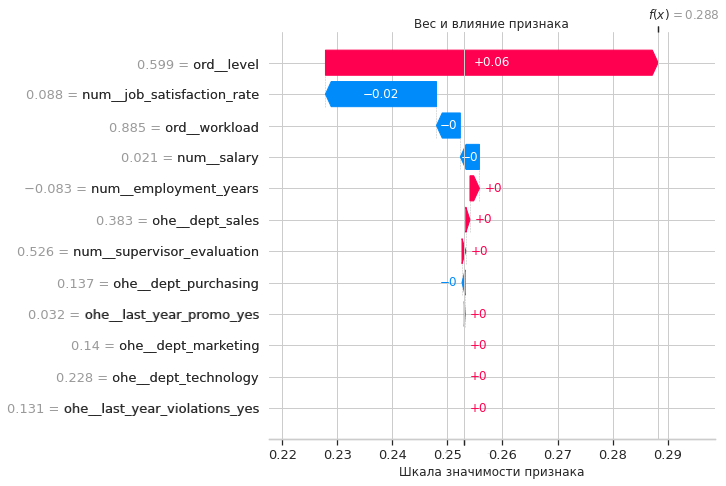

In [81]:
# Визуализация
shap_values_sum = 0
for i in range(1, len(shap_values)):
    shap_values_sum += shap_values[i]
    
shap.plots.waterfall(((shap_values_sum / len(shap_values))[:,1]), max_display=12, show=False)
fig, ax = plt.gcf(), plt.gca()

cb_ax0 = fig.axes[0] 
cb_ax0.set_xlabel('Шкала значимости признака')

cb_ax1 = fig.axes[1] 
cb_ax1.tick_params( labelsize=0)
cb_ax1.set_xlabel('Вес и влияние признака')

plt.show()

Получили визуализацию, которую можно удачно использовать при подведении итогов

# Общий вывод:

# Задача 1:

Шаг 1: Загрузка данных
- Данные успешно загружены из файлов train_job_satisfaction_rate.csv, test_features.csv и test_target_job_satisfaction_rate.csv

Шаг 2: Предобработка данных
- Данные изучены, при необходимости выполнена предобработка

Шаг 3: Исследовательский анализ данных
- Проведен анализ всех признаков, выявлены особенности, которые нужно учесть при их подготовке

Шаг 4: Подготовка данных

- Заполнены пропуски
- Подготовка признаков выполнена в пайплайне с учетом особенностей каждого признака и модели
- Использовались два метода кодирования.

Шаг 5: Обучение моделей
- Обучено как две модели: одна линейная, а вторая — дерево решений
- Подобраны для моделей
- Для оценки качества использовалась метрика SMAPE
- Лучшая модель была выбрана на основе этой метрики

Шаг 6: Оформление выводов
- Проведен анализ результатов работы моделей, сделаны выводы о том, какая модель справилась лучше и почему

# Задача 2:

Шаг 1: Загрузка данных
- Данные успешно загружены из файлов train_quit.csv, test_features.csv и test_target_quit.csv

Шаг 2: Предобработка данных
- Данные изучены, при необходимости выполнена предобработка

Шаг 3: Исследовательский анализ данных
- Проведен исследовательский анализ данных.
- Составлен портрет уволившегося сотрудника: определены признаки, которые сильнее всего связаны с увольнением, такие как отдел уровень загруженности, зарплата
- Проверено утверждение об уровне удовлетворенности работой как факторе, влияющем на увольнение сотрудников, с помощью визуализации распределений признака job_satisfaction_rate для ушедших и оставшихся сотрудников

Шаг 4: Добавление нового входного признака
- Добавлен предсказанный уровень удовлетворенности работой к входным признакам для второй задачи

Шаг 5: Подготовка данных
- Выполнена подготовка признаков и заполнение пропусков в пайплайне с учетом особенностей каждого признака и модели, используя как минимум два кодировщика

Шаг 6: Обучение модели
- Обучено три модели, подобраны гиперпараметры для двух из них
- Оценено качество лучшей модели с помощью метрики ROC-AUC

Шаг 7: Выводы
- Сделаны промежуточные выводы о том, какая модель справилась лучше и почему, основываясь на оценке качества по метрике ROC-AUC

Дополнительный шаг:
- Построен график значимости признаков SHAP, по которому можно посмотреть значимость признаков, чтобы дать более точные рекомендации бизнесу(в порядке убывания):

1. level(positive) - уровень должности
2. job_satisfaction_rate(negative) - уровень удовлетворенности работой
3. salary(positive) - зарплата
4. workload(negative) - уровень загруженности
5. employment_years(positive) - стаж работы в компании


# Рекомендации для бизнеса:

Основное внимание следует сосредоточить на ключевых признаках, оказывающих наибольшее влияние на решение о увольнении сотрудников(по убыванию):

1. Уровень должности (level):
- Отдать предпочтение работы с новичками, обеспечивая им перспективы карьерного роста и заинтересовывая их новыми направлениями
2. Уровень удовлетворенности работой (job_satisfaction_rate):
- Проанализировать причины неудовлетворенности сотрудников работой и предпринять меры для снижения их влияния
3. Зарплата (salary):
- Провести индивидуальный анализ и точный расчет экономической целесообразности увеличения заработной платы для работников с низкой(в сравнении со средней) зарплатой
4. Уровень загруженности (workload):
- Рассмотреть возможность увеличения нагрузки на сотрудника и одновременно повышения его заработной платы, статуса или удовлетворенностью работы для снижения вероятности увольнения
5. Стаж работы в компании (employment_years):
- Заинтересовать и мотивировать новых специалистов, работающих в компании менее двух лет, чтобы снизить вероятность их увольнения

Уделите особое внимание работникам, наиболее склонным оказаться в числе уволившихся, в соответствии с портретом, составленным в разделе 2.3.


#  Вывод:

В ходе работы были изучены данные, подготовлены признаки, обучены и оценены модели для прогнозирования уровня удовлетворенности работой сотрудников и вероятности их увольнения.

Были проведены все этапы работы: от загрузки данных до подбора гиперпараметров и оценки качества моделей.

Лучшая модель была выбрана на основе метрики SMAPE и успешно прошла критерий успеха.

Полученные результаты могут быть использованы для принятия управленческих решений в компании